## Import Libraries

In [5]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required resources for NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Word2Vec and BERT dependencies
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

import torch
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Dataset Loading and Exploration

In [6]:
# Read in 500 data
df = pd.read_csv('/content/Amazon_Fine_Food_Reviews.csv')
print(df.shape)
df_downsize = df.head(500)
print(df.shape)

#Review for 1st row under the Text column
df['Text'].values[0]


(6263, 10)
(6263, 10)


'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [7]:
# all columns
print('Food Review')
print(df.columns)
df['Score'].value_counts()


Food Review
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


,count
Score,
5,4017
4,844
1,576
3,478
2,348


## Checking missing values

In [8]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,1


### Removing Duplicate value

In [9]:
df_rd_cleaned = df.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Text'], keep='first')
print(df_rd_cleaned.shape, df_rd_cleaned['Text'].value_counts())
df_rd_cleaned['Score'].value_counts()

(6240, 10) Text
i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

,count
Score,
5,4004
4,843
1,573
3,476
2,344


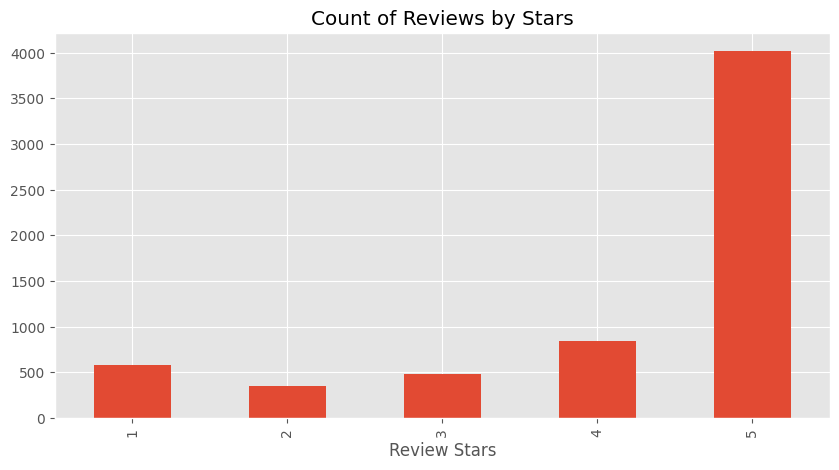

In [10]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Text Review Cleaning & Pre-Processing

In [11]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Remove HTML tags (adjusted to handle edge cases better)
    text = re.sub(r'<.*?>', ' ', text)  # Replaces HTML tags with a space to avoid concatenation

    # Remove special characters, numbers, and punctuations (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase and strip leading/trailing whitespaces
    text = text.lower().strip()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and apply lemmatization
    cleaned_tokens = [
        lemmatizer.lemmatize(token) for token in tokens if token not in stop_words
    ]

    # Return the cleaned text as a space-separated string
    return ' '.join(cleaned_tokens)

# Sample DataFrame for demonstration (assuming 'df_rd_cleaned' already exists)
df = df_rd_cleaned.head(10000)

# Apply text cleaning to the 'Text' column
df.loc[:, 'cleaned_review'] = df['Text'].apply(clean_text)

# Drop rows with missing values in the 'cleaned_review' or 'Score' columns
df.dropna(subset=['cleaned_review', 'Score'], inplace=True)

# Ensure the 'Score' column is in integer format
df['Score'] = df['Score'].astype(int)

# Define a function to map scores to sentiment labels
def map_review(x):
    if x < 3:
        return 'Negative'
    elif x == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Create binary and categorical sentiment labels
df['Review'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)  # Binary sentiment
df['label'] = df['Score'].apply(lambda x: map_review(x))       # Categorical sentiment




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-11-19ebe25f249e>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cleaned_review'] = df['Text'].apply(clean_text)
<ipython-input-11-19ebe25f249e>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

## Generate a word cloud

Word Cloud for Positive Reviews


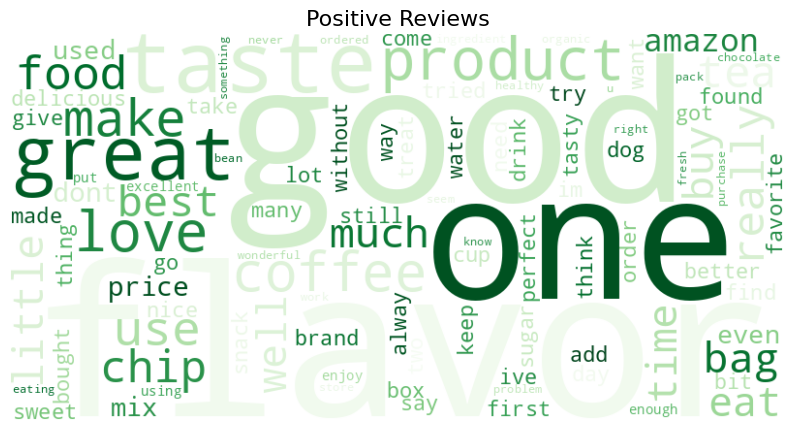

Word Cloud for Negative Reviews


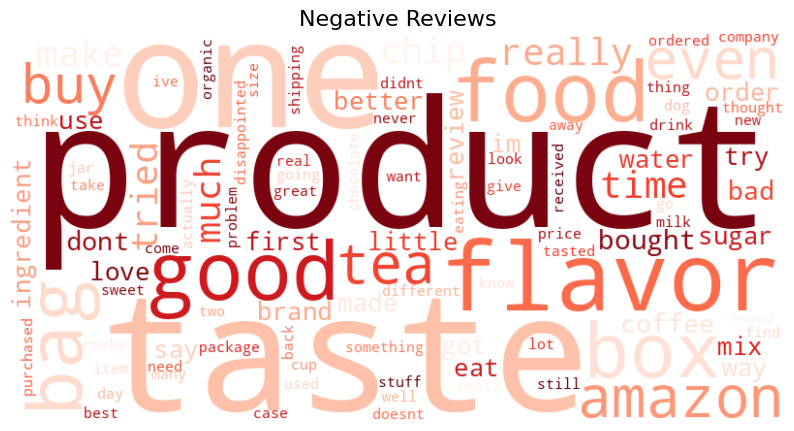

Word Cloud for Neutral Reviews


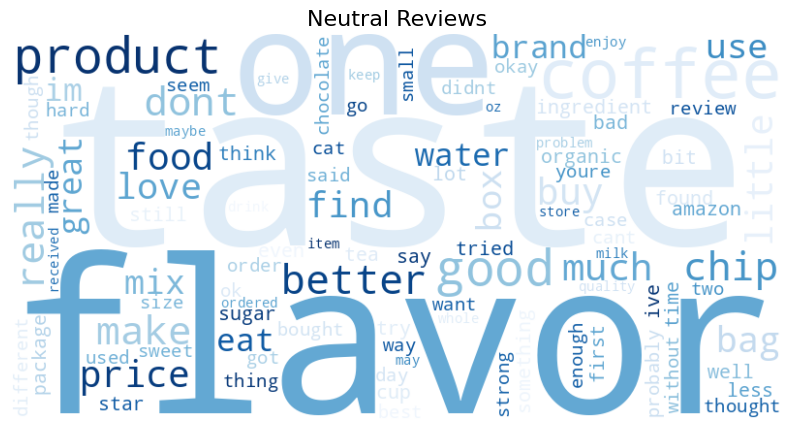

In [12]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt

# Filter reviews by label
positive_reviews = ' '.join(df[df['label'] == 'Positive']['cleaned_review'])
negative_reviews = ' '.join(df[df['label'] == 'Negative']['cleaned_review'])
neutral_reviews = ' '.join(df[df['label'] == 'Neutral']['cleaned_review'])

# Define a function to create and plot a word cloud
def plot_wordcloud(text, title, color='viridis'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axes
    plt.title(title, fontsize=16)
    plt.show()

# Plot word clouds for positive, negative, and neutral reviews
print("Word Cloud for Positive Reviews")
plot_wordcloud(positive_reviews, "Positive Reviews", color='Greens')

print("Word Cloud for Negative Reviews")
plot_wordcloud(negative_reviews, "Negative Reviews", color='Reds')

print("Word Cloud for Neutral Reviews")
plot_wordcloud(neutral_reviews, "Neutral Reviews", color='Blues')



### Data split for training and testing

## Data Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['Review'], test_size=0.30, random_state=42, stratify=df['Score'])


In [14]:
X_train.shape, X_test.shape

((4368,), (1872,))

## Feature Extraction

### TF-IDF Vectorize the Data

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=150000, analyzer='char', ngram_range=(3, 6))
vectorizer_word = TfidfVectorizer(max_features=150000, ngram_range=(1, 4), analyzer='word')

# Fit on training data and transform both train and test datasets
X_train_vec_char = vectorizer.fit_transform(X_train)
X_test_vec_char = vectorizer.transform(X_test)

X_train_vec_word = vectorizer_word.fit_transform(X_train)
X_test_vec_word = vectorizer_word.transform(X_test)

# Print shapes
X_train_vec_char.shape, X_test_vec_char.shape, X_train_vec_word.shape, X_test_vec_word.shape, y_train.shape, y_test.shape



((4368, 150000),
 (1872, 150000),
 (4368, 150000),
 (1872, 150000),
 (4368,),
 (1872,))

## Balancing data

### SMOTE (Synthetic Minority Oversampling Technique) resample

In [16]:
#Use imblearn.over_sampling to access SMOTE methods to modify the class distribution of the training set to handle class imbalance
#from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to balance the dataset (only for the training data)
smote = SMOTE(random_state=42)

# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_vec_word, y_train)

# Check class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution before SMOTE: Counter({1: 3393, 0: 975})
Class distribution after SMOTE: Counter({1: 3393, 0: 3393})


### ROS (Random Oversampling) resample

In [17]:
#Use imblearn.over_sampling to access RandomOverSampler to methods modify the class distribution of the training set to handle class imbalance
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
# Apply ROS to the training data
X_train_ros, y_train_ros = ros.fit_resample(X_train_vec_word, y_train)

# Check class distribution after oversampling
from collections import Counter
print("Before ROS:", Counter(y_train))
print("After ROS:", Counter(y_train_ros))

print("Before ROS:", Counter(y_test))


Before ROS: Counter({1: 3393, 0: 975})
After ROS: Counter({1: 3393, 0: 3393})
Before ROS: Counter({1: 1454, 0: 418})


## Model Training

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

### Function to store model result

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a DataFrame to store results
model_results_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'F1 Score', 'Precision', 'Recall'])

# Function to store results for each model
def store_model_results(model_name, X_train, y_train, X_test, y_test, y_pred_test, y_pred_train):
    # Calculate accuracy for training and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Calculate other metrics for the test set
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)

    # Append results to the DataFrame
    model_results_df.loc[len(model_results_df)] = {
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

### Random Forrest using SMOTE

In [20]:
# Train and evaluate the Random Forest model
rf_model_smote = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Predict on the train set
y_pred_rf_smote_train = rf_model_smote.predict(X_train_smote)

# Predict on the test set
y_pred_rf_smote_test = rf_model_smote.predict(X_test_vec_word)

# Store the Random Forest results (train and test accuracies, along with other metrics)
store_model_results('Random Forest SMOTE', X_train_smote, y_train_smote, X_test_vec_word, y_test, y_pred_rf_smote_test, y_pred_rf_smote_train)

# Display the classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_smote_test))

# Print accuracy score
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf_smote_test):.4f}")

# Display the results for the first 10 predictions
print("\nFirst 10 Predictions vs Actual Values:")
for i in range(10):
    print(f"Prediction: {y_pred_rf_smote_test[i]}, Actual: {y_test.iloc[i]}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.13      0.22       418
           1       0.80      0.98      0.88      1454

    accuracy                           0.79      1872
   macro avg       0.72      0.56      0.55      1872
weighted avg       0.76      0.79      0.73      1872

Random Forest Accuracy: 0.7906

First 10 Predictions vs Actual Values:
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1


### Random Forrest using ROS

In [21]:
# Initialize the models
rf_model_ros = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train Random Forest
rf_model_ros.fit(X_train_ros, y_train_ros)

# Predict on the train set
y_pred_rf_ros_train = rf_model_ros.predict(X_train_ros)

# Predict on the test set
y_pred_rf_ros_test = rf_model_ros.predict(X_test_vec_word)

# Store the results
store_model_results('Random Forest ROS', X_train_ros, y_train_ros, X_test_vec_word, y_test, y_pred_rf_ros_test, y_pred_rf_ros_train)

# Evaluate the models
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_ros_test))

# Compare Accuracy
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf_ros_test):.4f}")

# Display the results for the first 10 predictions
print("\nFirst 10 Predictions vs Actual Values:")
for i in range(10):
    print(f"Prediction: {y_pred_rf_ros_test[i]}, Actual: {y_test.iloc[i]}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.29      0.43       418
           1       0.83      0.98      0.90      1454

    accuracy                           0.83      1872
   macro avg       0.82      0.63      0.66      1872
weighted avg       0.83      0.83      0.79      1872

Random Forest Accuracy: 0.8269

First 10 Predictions vs Actual Values:
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1


#### SVM using ROS

In [22]:
# Initialize the models
from sklearn.svm import SVC

svm_model_ros = SVC(kernel='linear', random_state=42)

# Train SVM
svm_model_ros.fit(X_train_ros, y_train_ros)

# Predict on the train set
y_pred_svm_ros_train = svm_model_ros.predict(X_train_ros)

# Predict on the test set
y_pred_svm_ros_test = svm_model_ros.predict(X_test_vec_word)

# Store the results
store_model_results('SVM ROS', X_train_ros, y_train_ros, X_test_vec_word, y_test, y_pred_svm_ros_test, y_pred_svm_ros_train)

# Evaluate the models
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm_ros_test))

# Compare Accuracy
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm_ros_test):.4f}")

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.51      0.61       418
           1       0.87      0.95      0.91      1454

    accuracy                           0.85      1872
   macro avg       0.81      0.73      0.76      1872
weighted avg       0.84      0.85      0.84      1872

SVM Accuracy: 0.8510


### SVM using SMOTE

In [23]:
svm_model_smote = SVC(kernel='linear', random_state=42)

# Train SVM
svm_model_smote.fit(X_train_smote, y_train_smote)
# Predict on the train set
y_pred_svm_smote_train = svm_model_smote.predict(X_train_smote)

# Predict on the test set
y_pred_svm_smote_test = svm_model_smote.predict(X_test_vec_word)
# Store the results
store_model_results('SVM SMOTE', X_train_ros, y_train_ros, X_test_vec_word, y_test, y_pred_svm_smote_test, y_pred_svm_smote_train)


#### Logistic Regression using ROS

In [24]:
from sklearn.linear_model import LogisticRegression

lr_model_ros = LogisticRegression(max_iter=1000,class_weight='balanced', random_state=42)
lr_model_ros.fit(X_train_ros, y_train_ros)

# Predict on the test set and training set
y_pred_lr_ros_test = lr_model_ros.predict(X_test_vec_word)
y_pred_lr_ros_train = lr_model_ros.predict(X_train_ros)

# Store the results
store_model_results('Logistic Regression ROS', X_train_ros, y_train_ros, X_test_vec_word, y_test, y_pred_lr_ros_test, y_pred_lr_ros_train)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr_ros_test))
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr_ros_test):.4f}")



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       418
           1       0.90      0.91      0.90      1454

    accuracy                           0.85      1872
   macro avg       0.78      0.77      0.77      1872
weighted avg       0.84      0.85      0.85      1872

Logistic Regression Accuracy: 0.8467


#### Logistic Regression using SMOTE

In [25]:
lr_model_smote = LogisticRegression(max_iter=1000,class_weight='balanced', random_state=42)
lr_model_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set and training set
y_pred_lr_smote_test = lr_model_smote.predict(X_test_vec_word)
y_pred_lr_smote_train = lr_model_smote.predict(X_train_smote)

# Store the results
store_model_results('Logistic Regression SMOTE', X_train_ros, y_train_ros, X_test_vec_word, y_test, y_pred_lr_smote_test, y_pred_lr_smote_train)


### Overall result for all models

In [26]:
model_results_df

,Model,Train Accuracy,Test Accuracy,F1 Score,Precision,Recall
0,Random Forest SMOTE,1.000000,0.790598,0.879012,0.797312,0.979367
1,Random Forest ROS,1.000000,0.826923,0.898113,0.827346,0.982118
2,SVM ROS,0.999558,0.850962,0.908072,0.871600,0.947730
3,SVM SMOTE,0.999853,0.851496,0.908190,0.873571,0.945667
4,Logistic Regression ROS,0.991748,0.846688,0.902014,0.895593,0.908528
5,Logistic Regression SMOTE,0.989685,0.841880,0.898282,0.897665,0.898900


## Visualization and Insights

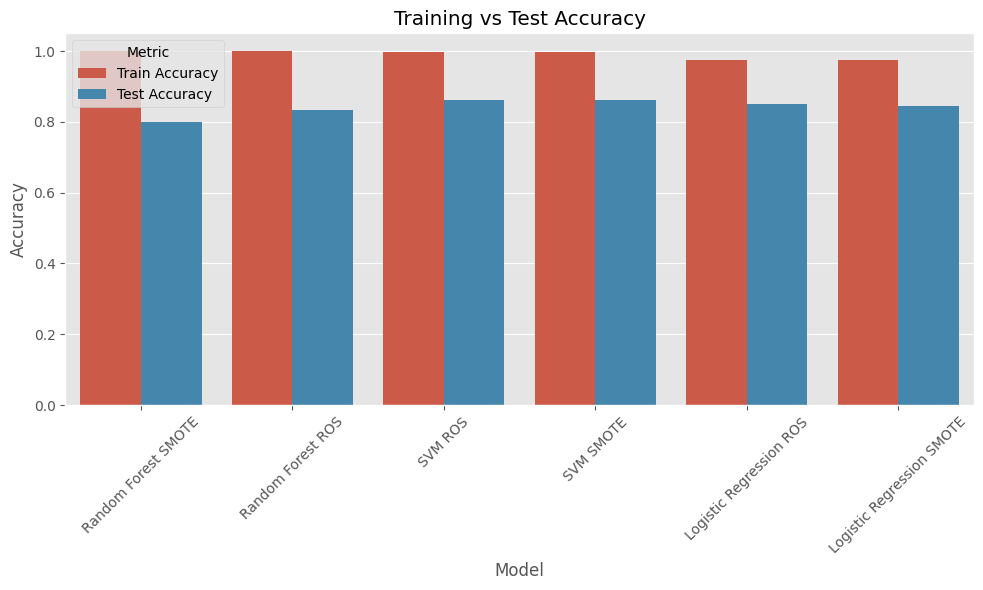

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is already loaded into the model_results_df
# Sample data from your provided input (you can load your actual data)
data = {
    "Model": [
        "Random Forest SMOTE", "Random Forest ROS", "SVM ROS", "SVM SMOTE", "SVM SMOTE",
        "Logistic Regression ROS", "Logistic Regression SMOTE", "Logistic Regression SMOTE"
    ],
    "Train Accuracy": [
        1.0, 1.0, 0.9976644245142003, 0.9985052316890882, 0.9985052316890882,
        0.9744955156950673, 0.9759902840059791, 0.9759902840059791
    ],
    "Test Accuracy": [
        0.8006666666666666, 0.8323333333333334, 0.861, 0.862, 0.862,
        0.8496666666666667, 0.846, 0.846
    ],
    "F1 Score": [
        0.8818181818181818, 0.8987723888106259, 0.9117460317460317, 0.9123252858958069, 0.9123252858958069,
        0.9007263922518159, 0.8978779840848806, 0.8978779840848806
    ],
    "Precision": [
        0.8065798987707882, 0.8347663551401869, 0.886055121349239, 0.8871499176276771, 0.8871499176276771,
        0.9097376611827479, 0.910762331838565, 0.910762331838565
    ],
    "Recall": [
        0.9725370531822145, 0.9734088927637314, 0.9389712292938099, 0.9389712292938099, 0.9389712292938099,
        0.8918918918918919, 0.8853530950305144, 0.8853530950305144
    ]
}

# Load into DataFrame
model_results_df = pd.DataFrame(data)

# 1. Bar Plot for Training vs Test Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="value", hue="Metric", data=pd.melt(model_results_df, id_vars=["Model"],
                                                           value_vars=["Train Accuracy", "Test Accuracy"],
                                                           var_name="Metric", value_name="value"))
plt.xticks(rotation=45)
plt.title('Training vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.tight_layout()
plt.show()




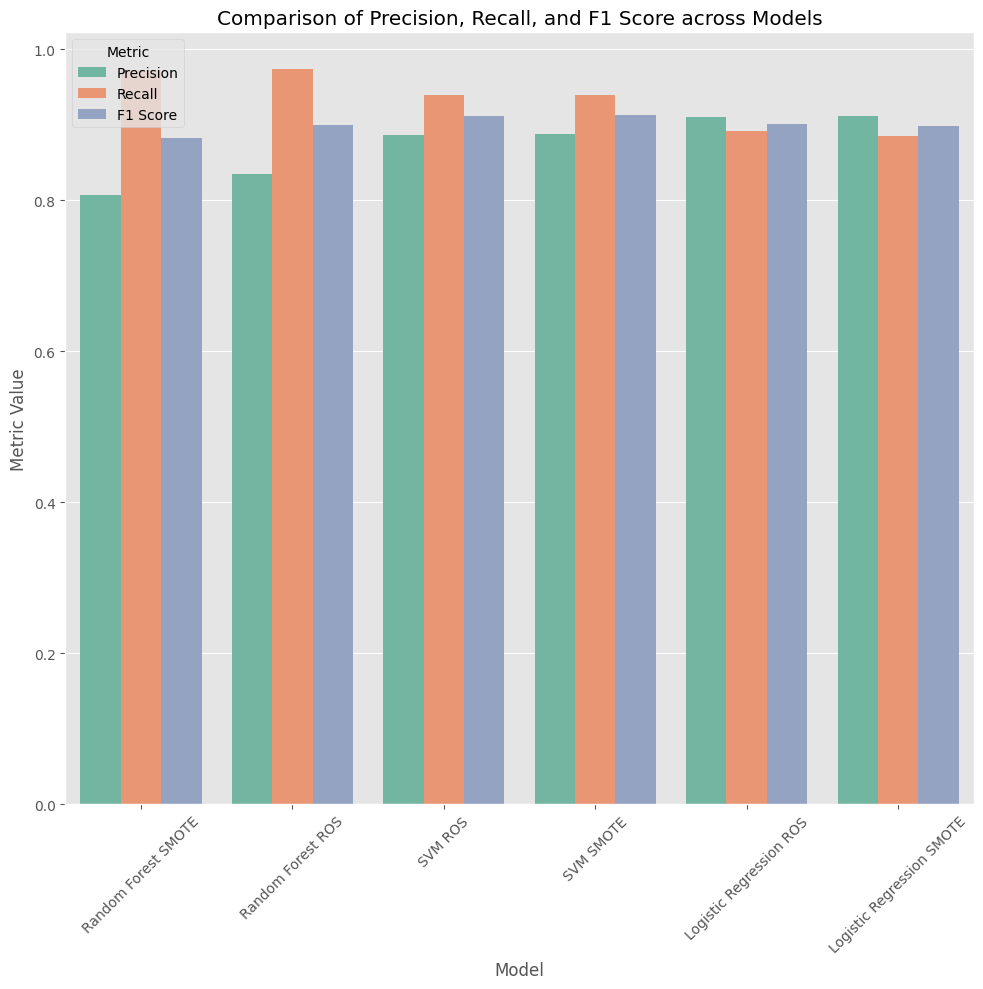

In [28]:
# 2. Bar Plot for Precision, Recall, and F1 Score
metrics_df = pd.melt(model_results_df, id_vars=["Model"],
                     value_vars=["Precision", "Recall", "F1 Score"],
                     var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 10))
sns.barplot(x="Model", y="Value", hue="Metric", data=metrics_df, palette='Set2')
plt.xticks(rotation=45)
plt.title('Comparison of Precision, Recall, and F1 Score across Models')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


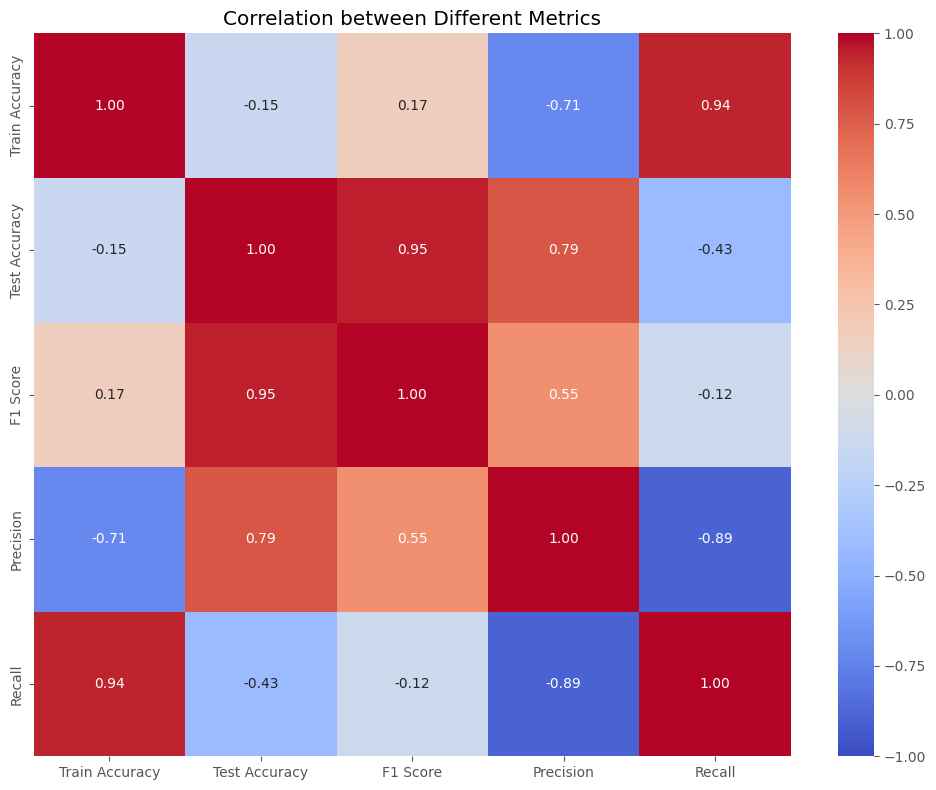

In [29]:

# 3. Heatmap for Correlation between the metrics
correlation_matrix = model_results_df.drop(columns=["Model"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Different Metrics")
plt.tight_layout()
plt.show()



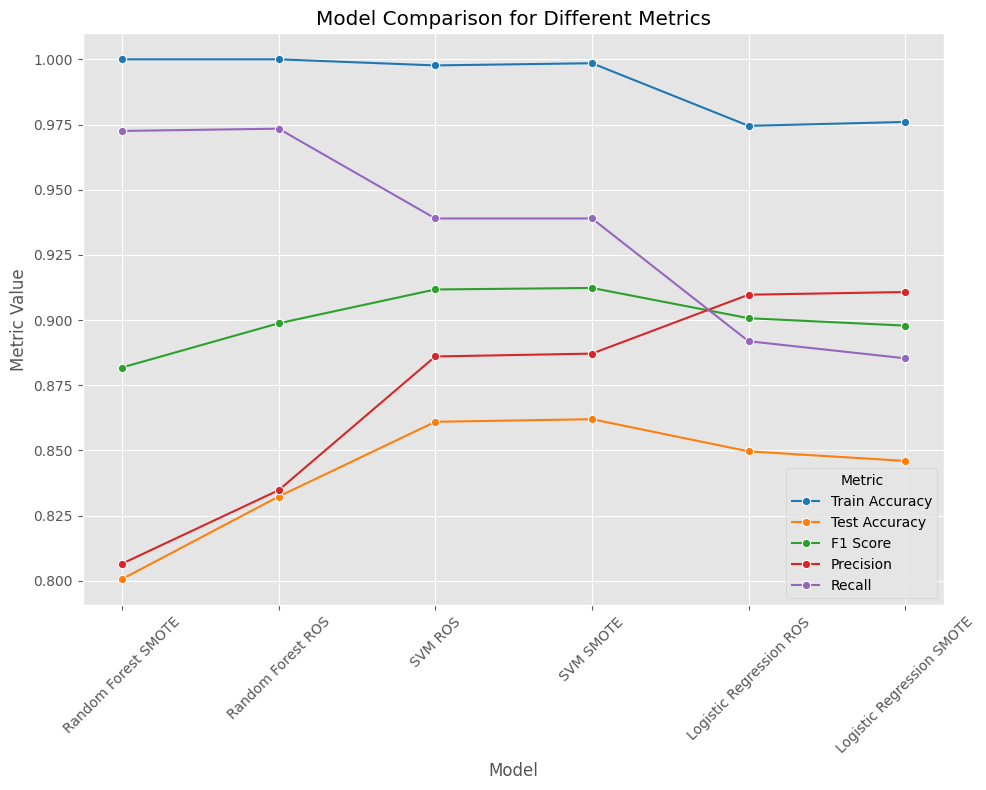

In [30]:
# 4. Line Plot for Overall Comparison of Metrics
metrics_long_df = pd.melt(model_results_df, id_vars=["Model"],
                          value_vars=["Train Accuracy", "Test Accuracy", "F1 Score", "Precision", "Recall"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 8))
sns.lineplot(x="Model", y="Value", hue="Metric", data=metrics_long_df, marker="o", palette="tab10")
plt.xticks(rotation=45)
plt.title('Model Comparison for Different Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

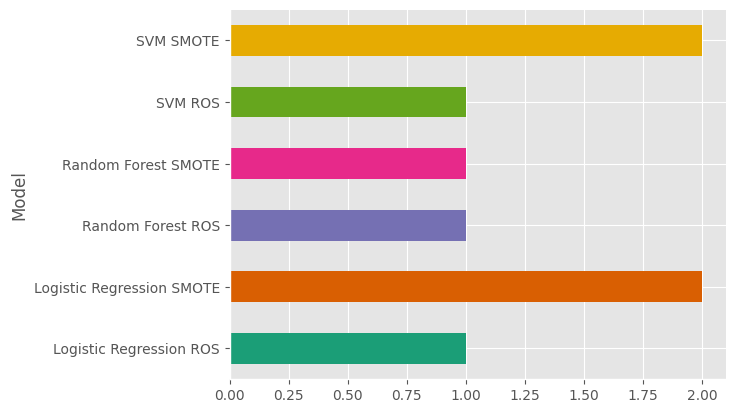

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
model_results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Model Evaluation

In [53]:
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [54]:
import random
random.seed(42)  # For any random operations

N=5


df['cleaned_review']

,cleaned_review
0,bought several vitality canned dog food produc...
1,product arrived labeled jumbo salted peanutsth...
2,confection around century light pillowy citrus...
3,looking secret ingredient robitussin believe f...
4,great taffy great price wide assortment yummy ...
...,...
6258,sleepytime tea one tea always counted mellow g...
6259,valerian chamomile blended spearmint leaf lemo...
6260,wonderful product drink time day obviously ori...
6261,product great daughter extremely pick love als...


In [55]:
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join(x.split()))



<ipython-input-55-8e3d55abe620>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
df['cleaned_review']=df['cleaned_review'].str.replace("br","")

<ipython-input-56-45502d3114c0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
from collections import defaultdict
import plotly.express as px
import pandas as pd

# Initialize the defaultdict to store unigram counts
less_toxic_unigrams = defaultdict(int)
for tweet in df['cleaned_review']:
    for word in generate_ngrams(tweet, 1):  # Assuming generate_ngrams is defined elsewhere
        less_toxic_unigrams[word] += 1

# Convert the unigram counts into a DataFrame and sort by frequency
#df_less_toxic_unigrams = pd.DataFrame(sorted(less_toxic_unigrams.items(), key=lambda x: x[1], reverse=True))
df_less_toxic_unigrams = pd.DataFrame(
    sorted(less_toxic_unigrams.items(), key=lambda x: (-x[1], x[0]))  # Sort by frequency, then alphabetically
)
# Slice the top N unigrams
#unigrams_less_11 = df_less_toxic_unigrams[:N]
unigrams_less_11 = df_less_toxic_unigrams.iloc[:N]  # Use `iloc` for slicing by position
# Create the bar plot using Plotly Express
fig = px.bar(
    x=unigrams_less_11[1],  # Frequency (x-axis)
    y=unigrams_less_11[0],  # Unigrams (y-axis)
    orientation='h',  # Horizontal bar chart
    color=unigrams_less_11[1],  # Color based on frequency (x-axis)
    color_continuous_scale=["#f59090", "#f53838"]  # Two-color scale: dark green for high frequency, light yellow for low frequency
)

# Update the layout of the plot with titles and styling
fig.update_layout(
    title="<b>Top 10 Most Common Unigrams in Text</b>",
    xaxis_title="<b>Frequency</b>",  # Title for the x-axis
    yaxis_title="<b>Unigrams</b>",  # Title for the y-axis
    font_size=18,
    plot_bgcolor="#fff",
    showlegend=False
)

# Show the plot
fig.show()


In [60]:
from collections import defaultdict
import plotly.express as px
import pandas as pd

# Initialize the defaultdict to store bigram counts
less_toxic_bigrams = defaultdict(int)
for tweet in df['cleaned_review']:
    for bigram in generate_ngrams(tweet, 2):  # Assuming generate_ngrams is deterministic
        less_toxic_bigrams[bigram] += 1

# Convert the bigram counts into a DataFrame and sort deterministically
df_less_toxic_bigrams = pd.DataFrame(
    sorted(less_toxic_bigrams.items(), key=lambda x: (-x[1], x[0]))
)

# Slice the top N bigrams
bigrams_less_11 = df_less_toxic_bigrams.iloc[:N]

# Create the bar plot using Plotly Express
fig = px.bar(
    x=bigrams_less_11[1],  # Frequency (x-axis)
    y=bigrams_less_11[0],  # Bigrams (y-axis)
    orientation='h',  # Horizontal bar chart
    color=bigrams_less_11[1],  # Color based on frequency (x-axis)
    color_continuous_scale=["#f0af3e", "#966002"]  # Two-color scale: dark yellow to brown
)

# Update the layout of the plot with titles and styling
fig.update_layout(
    title="<b>Top 10 Most Common Bigrams in Text</b>",
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Bigrams</b>",
    font_size=18,
    plot_bgcolor="#fff",
    showlegend=False
)

# Show the plot
fig.show()

In [62]:
from collections import defaultdict
import plotly.express as px
import pandas as pd

# Initialize the defaultdict to store trigram counts
less_toxic_trigrams = defaultdict(int)
for tweet in df['cleaned_review']:
    for trigram in generate_ngrams(tweet, 3):  # Assuming generate_ngrams is deterministic
        less_toxic_trigrams[trigram] += 1

# Convert the trigram counts into a DataFrame and sort deterministically
df_less_toxic_trigrams = pd.DataFrame(
    sorted(less_toxic_trigrams.items(), key=lambda x: (-x[1], x[0]))
)

# Slice the top N trigrams
trigrams_less_11 = df_less_toxic_trigrams.iloc[:N]

# Create the bar plot using Plotly Express
fig = px.bar(
    x=trigrams_less_11[1],  # Frequency (x-axis)
    y=trigrams_less_11[0],  # Trigrams (y-axis)
    orientation='h',  # Horizontal bar chart
    color=trigrams_less_11[1],  # Color based on frequency (x-axis)
    color_continuous_scale=["#004529", "#f6fcb8"]  # Two-color scale: dark green to light yellow
)

# Update the layout of the plot with titles and styling
fig.update_layout(
    title="<b>Top 10 Most Common Tri-grams in Text</b>",
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Tri-grams</b>",
    font_size=18,
    plot_bgcolor="#fff",
    showlegend=False
)

# Show the plot
fig.show()

### Topic Modeling for Understanding Review Themes
Use Latent Dirichlet Allocation (LDA) to identify the common topics in reviews. You can compare topics in reviews with high ratings (4-5 stars) vs. low ratings (1-2 stars).

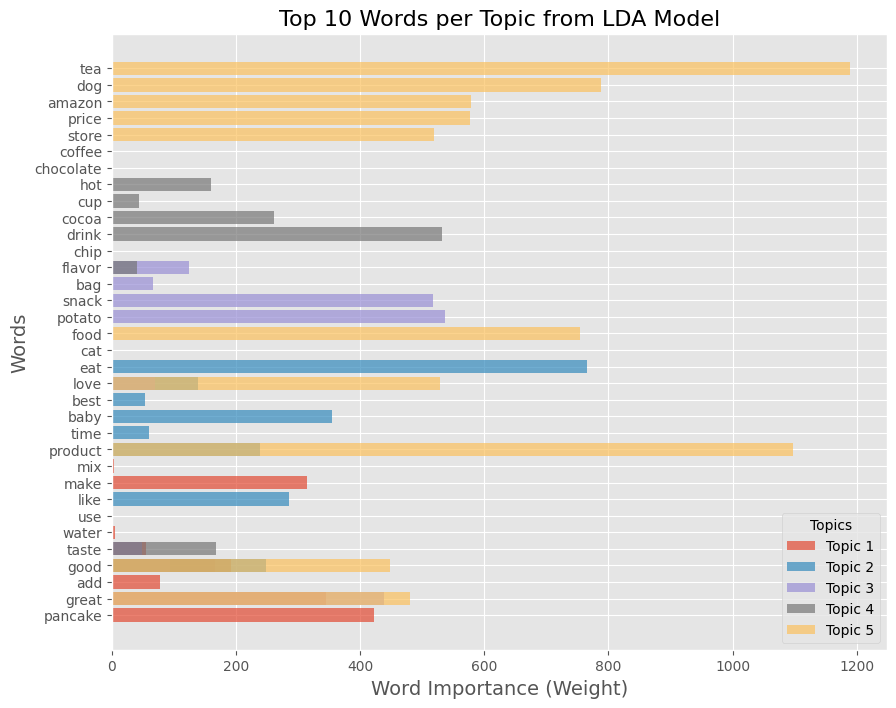

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the cleaned reviews
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['cleaned_review'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Number of words to display per topic
n_words = 10

# Prepare the data for visualization
top_words = {}
for idx, topic in enumerate(lda.components_):
    top_words[idx] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-n_words:]]

# Flatten the data to plot
topics = []
words = []
for idx, words_list in top_words.items():
    topics.extend([f"Topic {idx + 1}"] * n_words)
    words.extend(words_list)

# Create a DataFrame for better handling
df_top_words = pd.DataFrame({
    'Topic': topics,
    'Word': words,
    'Weight': np.concatenate([lda.components_[idx][topic.argsort()[-n_words:]] for idx in range(lda.components_.shape[0])])
})

# Plotting the bar chart
plt.figure(figsize=(10, 8))
for i in range(lda.components_.shape[0]):
    topic_df = df_top_words[df_top_words['Topic'] == f'Topic {i + 1}']
    plt.barh(topic_df['Word'], topic_df['Weight'], label=f'Topic {i + 1}', alpha=0.7)

plt.xlabel('Word Importance (Weight)', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top 10 Words per Topic from LDA Model', fontsize=16)
plt.legend(title='Topics')
plt.show()


### Reviewer Consistency Analysis
Calculate the consistency of each reviewer by comparing their historical ratings and sentiment.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)

# Step 1: Count number of reviews per userId
reviews_per_user = df.groupby('userId').size()

# Step 2: Classify reviews as Positive, Neutral, or Negative
def categorize_review(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['ReviewCategory'] = df['Rating'].apply(categorize_review)

# Step 3: Count the number of positive, neutral, and negative reviews for each userId
reviews_category_per_user = df.groupby(['userId', 'label']).size().unstack(fill_value=0)

# Step 4: Plot the graphs

# Plot 1: Number of reviews per userId
plt.figure(figsize=(10, 6))
reviews_per_user.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews per User')
plt.xlabel('User ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

# Plot 2: Count of Positive, Neutral, Negative reviews per userId
reviews_category_per_user.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Review Categories per User')
plt.xlabel('User ID')
plt.ylabel('Count of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Review Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


KeyError: 'userId'